
# Object Detection using TensorFlow and Pascal VOC 2007 Dataset

In this exercise, we will adapt our image classification task to an object detection task. Object detection involves not only classifying objects within an image but also localizing them with bounding boxes.

Note: Due to the limited computational resources available, we'll be using a smaller subset of the Pascal VOC 2007 dataset and a lightweight object detection model. This might result in lower accuracy, but the focus of this exercise is on understanding the concepts and workflow of object detection.

## Steps:
1. Install (if necessary) and Import the libraries you will need for this project
2. Load the Pascal VOC 2007 dataset
3. Use a pre-trained object detection model (SSD MobileNet V2)
4. Display detected objects with bounding boxes
    

In [ ]:
%pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib


In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from io import BytesIO

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1



### Load the VOC2007 dataset

We will use the VOC2007 dataset, which contains images with annotations for object detection. For demonstration purposes, we will load a small subset of the dataset using TensorFlow Datasets.

- VOC2007 is a dataset for object detection, segmentation, and image classification.
- We define a function load_data to load the COCO dataset.
- tfds.load is a function that downloads and prepares the dataset.
- We use only 1% of the training data to keep the demonstration manageable.
- shuffle_files=True ensures that we get a random sample of the dataset.
- with_info=True returns additional information about the dataset, which we'll use later.

- The PASCAL VOC2007 (Visual Object Classes) dataset is a widely used benchmark dataset for object recognition tasks in computer vision. It comprises a collection of images annotated with bounding boxes and class labels for objects belonging to 20 different categories.

Key characteristics of the VOC2007 dataset:

- Purpose: Primarily used for training and evaluating object detection algorithms, but also applicable to other tasks like image classification and semantic segmentation.
- Object Categories: Includes a diverse set of 20 object classes, ranging from people and animals to vehicles and indoor items.
- Data Format: The dataset provides images along with corresponding annotation files containing bounding box coordinates and class labels for each object in the image.
- Image Variety: Features a wide range of images captured in diverse real-world scenarios, offering realistic challenges for object recognition models.
- Benchmark: Serves as a standard benchmark for comparing the performance of different object detection algorithms, fostering progress in the field.

Common use cases of the VOC2007 dataset:
- Training: Used as training data to teach object detection models to identify and localize objects within images.
- Evaluation: Employed to evaluate the performance of trained models by comparing their predictions against the ground truth annotations.
- Research: Utilized in research to develop and test new object detection algorithms and techniques.

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Load a smaller dataset
def load_data(split='train'):
    dataset, info = tfds.load('voc/2007', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Load the train dataset and extract info
train_dataset, train_info = load_data('train[:10%]')

# Load the validation dataset
validation_dataset, validation_info = load_data('validation[:10%]')

# Get class names
class_names = train_info.features["objects"]["label"].names  # Changed from ds_info to train_info
print("Class names:", class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.OR9IUA_5.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.OR9IUA_5.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.OR9IUA_5.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/5.0.0. Subsequent calls will reuse this data.
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


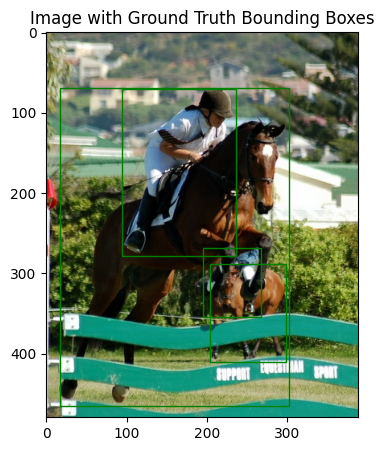

In [ ]:
def display_examples(dataset, n=1):  # Display 'n' examples by default
    for example in dataset.take(n):
        image = example["image"]
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title("Image with Ground Truth Bounding Boxes")
        # Draw ground truth boxes
        for box in example["objects"]["bbox"]:
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)
        plt.show()
display_examples(train_dataset)

### Find Images with Specific Classes

We got  the list of all class names in the VOC2007 dataset and select images containing our target classes (e.g., person, car, bird).

- `class_names` provides the list of class names.
- `target_class_ids` contains the IDs of the classes we are interested in.
- `find_images_with_classes` is a function to find images containing our target classes.


In [ ]:
def find_images_with_classes(dataset, class_names, target_classes):

    target_class_ids = [class_names.index(cls) for cls in target_classes if cls in class_names]
    if not target_class_ids:
        print(f"Warning: None of {target_classes} found in dataset class names.")
        return []

    images_with_classes = []
    for example in dataset:
        image_classes = example["objects"]["label"].numpy()
        if any(cls_id in target_class_ids for cls_id in image_classes):
            images_with_classes.append(example)
    return images_with_classes


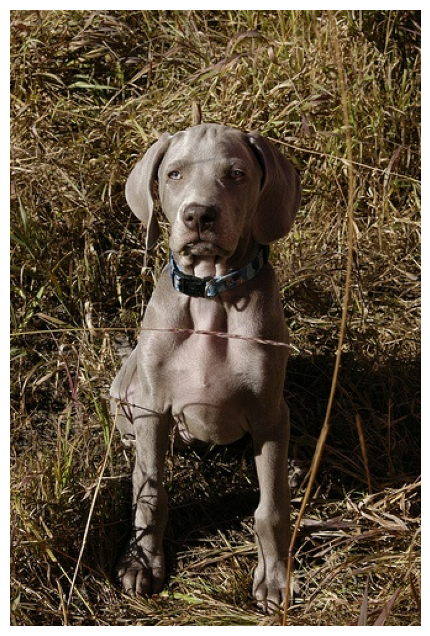

In [ ]:
images_with_dog = find_images_with_classes(train_dataset, class_names, target_classes=['dog'])

if images_with_dog:

    example_to_display = images_with_dog[4]

    image_to_display = example_to_display["image"].numpy()

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_to_display)
    plt.axis('off')
    plt.show()
else:
    print("No images")

### When To Load the model
Loading the model early (right after dataset loading):

Pros: Model is immediately available; clear separation of setup and processing.
Cons: Potentially inefficient if data prep is extensive or fails.


Loading the model after data preparation:

Pros: More efficient resource use; avoids unnecessary loading if data prep fails.
Cons: Model isn't available for any data prep steps that might need it.


In our specific case, loading the model after data preparation is slightly better because:

Our data prep doesn't need the model.
It's more resource-efficient.
It follows a logical flow: prepare data, load tools, process data.
It avoids unnecessary model loading if data prep fails.

However, the difference is minimal in this small-scale example. For beginners, loading major components upfront can sometimes be clearer and easier to follow.
As a best practice, aim to load your model as close as possible to where you'll use it, ensuring all necessary data and resources are ready first.

In [ ]:
#Load a pre-trained object detection model
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

Let's break this down:

- 1. hub.load(): This function is from TensorFlow Hub (tensorflow_hub). It downloads and loads models from the TensorFlow Hub repository.
- 2. "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2": This is the URL of the specific model we're loading. It's an SSD (Single Shot Detector) MobileNet V2 model, which is efficient for object detection tasks.
- 3. Detector: The loaded model is assigned to this variable. It becomes a callable object that you can use for object detection.

Advantages of this approach:

Concise and readable
Directly loads the model without additional wrapper functions
TensorFlow Hub handles caching, so subsequent loads will be faster

### Display Detected Objects with Bounding Boxes

We will use the pre-trained model to detect objects in our selected images and display them with bounding boxes.

- `detector` is the pre-trained object detection model.
- `detect_objects` is a function that uses the model to detect objects in an image.
- `display_detections` is a function to display the detected objects with bounding boxes.



### Helper Function to Display Bounding Boxes on Images

The `display_image_with_boxes` function takes an image, bounding boxes, and class names, then displays the image with bounding boxes drawn around detected objects.
- run_detector: This function prepares an image and runs it through our object detection model.
- plot_detections: This function visualizes the detected objects by drawing bounding boxes and labels on the image.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

In [ ]:
# Run Detector and Visualize
def run_detector_and_visualize(example):
    image = example["image"]
    ground_truth_boxes = example["objects"]["bbox"]

    # Preprocess and run detection
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    # Visualize results (with ground truth for comparison)
    plt.figure(figsize=(10, 7))
    plt.imshow(image)

    # Ground truth boxes (VOC format is [xmin, ymin, xmax, ymax])
    for box in ground_truth_boxes:
        ymin, xmin, ymax, xmax = box
        rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                linewidth=1, edgecolor='g', facecolor='none', label='Ground Truth')
        plt.gca().add_patch(rect)

    # Predicted boxes
    for i, score in enumerate(result['detection_scores'][0]):
        if score > 0.5:  # Confidence threshold
            ymin, xmin, ymax, xmax = result['detection_boxes'][0][i]
            class_id = int(result['detection_classes'][0][i])

            # Handle invalid class IDs (classes outside the VOC dataset)
            if class_id < len(class_names):
                label = class_names[class_id]

            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
            plt.gca().add_patch(rect)

            # Moved plt.text to the correct loop for the predicted box
            plt.text(xmin * image.shape[1], ymin * image.shape[0] - 5, f'{label}: {score:.2f}', color='white', backgroundcolor='r')

    plt.legend()
    plt.show()







###   Process and Display Images with Detections
The `detect_and_display` function runs object detection on an image and displays the results, as you saw above. The function converts the image to the appropriate format, runs the detector, and then uses the helper function to display the results.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

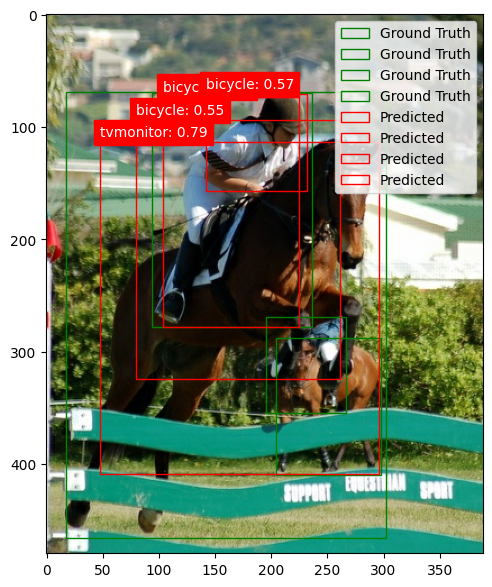

In [ ]:
# take a few examples from the training set
for example in train_dataset.take(1):  # Process 2 images
    run_detector_and_visualize(example)



#### Your Turn
Process a few images from the dataset
print("\nProcessing sample images from the dataset:") for i, example in enumerate(train_dataset.take(3)): print(f"\nSample image {i+1}") image = example['image'].numpy() detections = run_detector(detector, image) plot_detections(image, detections, class_names)


Sample image 1


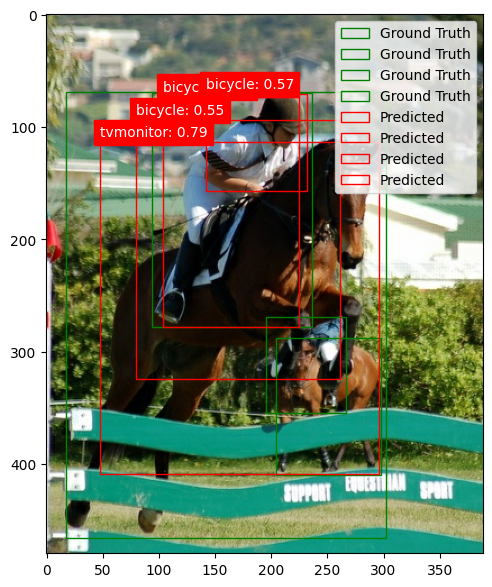


Sample image 2


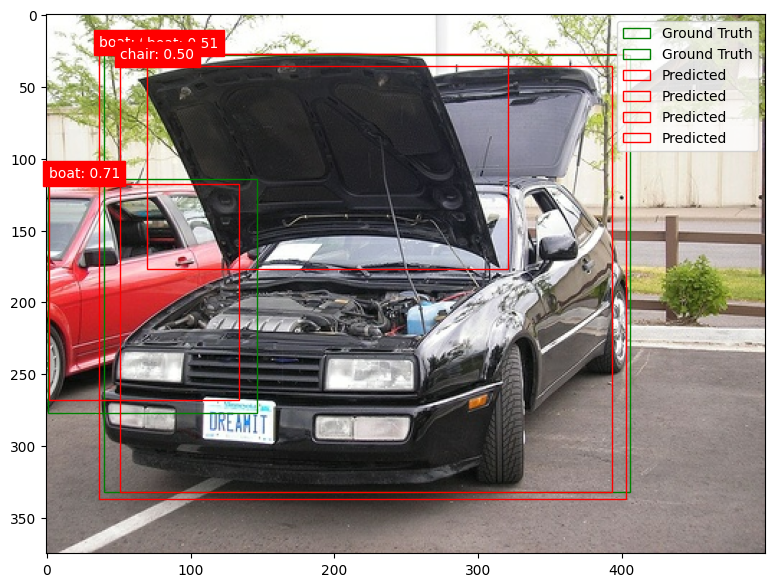


Sample image 3


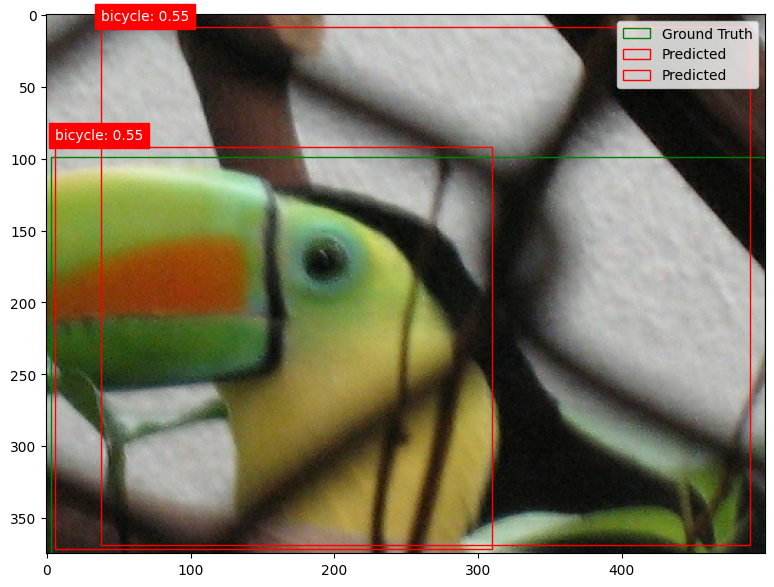

In [ ]:
for i, example in enumerate(train_dataset.take(3)):
    print(f"\nSample image {i+1}")
    run_detector_and_visualize(example)

## Mode Evaluation
###  Define the Evaluation Function

 The function called evaluate_model_performance which evaluates the performance of our object detection model on a dataset. The function takes three arguments: the dataset to evaluate on, the object detection model, and the number of images to use for evaluation. It calculates and prints the accuracy of the model based on the detections.   

In [ ]:
#Evaluate Model Performance
def evaluate_model_performance(dataset, detector, iou_threshold=0.8, num_samples=100):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for example in dataset.take(num_samples):
        image = example["image"].numpy()
        gt_boxes = example["objects"]["bbox"].numpy()
        gt_labels = example["objects"]["label"].numpy()

        # Preprocess and run detection (same as before)
        converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        pred_boxes = result['detection_boxes'][0]
        pred_scores = result['detection_scores'][0]
        pred_labels = result['detection_classes'][0].astype(int)

        # Iterate over predicted boxes
        for i, score in enumerate(pred_scores):
            if score < 0.5:  # Confidence threshold
                continue

            # Convert box coordinates to [ymin, xmin, ymax, xmax]
            pred_box = pred_boxes[i]
            pred_box = [pred_box[1], pred_box[0], pred_box[3], pred_box[2]]

            # Find matching ground truth box (if any) based on IoU
            best_iou = 0
            for j, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    gt_index = j

            # If IoU exceeds threshold, check class match
            if best_iou > iou_threshold:
                if pred_labels[i] == gt_labels[gt_index]:
                    true_positives += 1
                else:
                    false_positives += 1
            else:
                false_positives += 1

        # Count false negatives (missed ground truth boxes)
        false_negatives += len(gt_boxes) - true_positives

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Model Performance (IoU Threshold = {iou_threshold:.2f}):")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# (You'll need to implement a 'calculate_iou' function)
def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): Coordinates of the first box in the format [ymin, xmin, ymax, xmax].
        box2 (list): Coordinates of the second box in the same format.

    Returns:
        float: The IoU value (between 0 and 1).
    """

    # 1. Calculate coordinates of the intersection rectangle
    y1 = max(box1[0], box2[0])
    x1 = max(box1[1], box2[1])
    y2 = min(box1[2], box2[2])
    x2 = min(box1[3], box2[3])

    # 2. Calculate areas of the intersection and the union
    intersection_area = max(0, y2 - y1) * max(0, x2 - x1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # 3. Calculate IoU
    if union_area == 0:
        return 0  # Avoid division by zero
    else:
        iou = intersection_area / union_area
        return iou

# Evaluate model performance
print("Evaluating model performance...")
evaluate_model_performance(validation_dataset, detector)  # Use test data for evaluation


Evaluating model performance...
Model Performance (IoU Threshold = 0.80):
True Positives: 0
False Positives: 393
False Negatives: 331
Precision: 0.00
Recall: 0.00


### Object Detection Evaluation Core Concepts

* Object detection models need to be evaluated on two fronts:

- Classification Accuracy: Did the model correctly identify the object's class (e.g., person, car, bird)?
- Localization Accuracy: Did the model accurately draw a bounding box around the object?

 Our exercise  focuses on assessing localization accuracy using the Intersection over Union (IoU) metric.

* Understanding IoU (Intersection over Union)

IoU measures how much two bounding boxes overlap.

- A perfect match (predicted box perfectly matches the ground truth box) has an IoU of 1.
- No overlap has an IoU of 0.

The iou_threshold in the code (default 0.5) means a predicted box is considered a "true positive" only if its IoU with a ground truth box is 0.5 or higher.

* Output Interpretation:

The function will print the following metrics:

- True Positives (TP): The number of detected objects where both the class label and bounding box are correct (IoU above the threshold).
- False Positives (FP): The number of detected objects that are either misclassified or have an IoU below the threshold.
- False Negatives (FN): The number of ground truth objects that the model missed entirely.
- Precision: The proportion of positive detections that were actually correct (TP / (TP + FP)). A high precision means the model makes few false alarms.
- Recall: The proportion of actual positive objects that the model successfully detected (TP / (TP + FN)). A high recall means the model misses few objects.

Example Results:
Let's say the output is:

Model Performance (IoU Threshold = 0.50):
True Positives: 75
False Positives: 20
False Negatives: 15
Precision: 0.79
Recall: 0.83
Interpretation:

- The model correctly detected and localized 75 objects.
- It made 20 incorrect detections (wrong class or poor box placement).
- It missed 15 objects that were actually present in the images.
- Precision is 0.79, meaning 79% of the model's positive detections were accurate.
- Recall is 0.83, meaning the model found 83% of the actual objects in the images.

* Key Takeaways:
- Precision vs. Recall: There's often a trade-off between these two. Increasing the confidence threshold (e.g., to 0.6) might improve    precision (fewer false alarms) but likely lower recall (more missed objects).
- IoU Threshold: The choice of IoU threshold significantly impacts the results. A higher threshold makes the evaluation stricter, potentially lowering both precision and recall.
- Limitations: This evaluation only covers a limited number of samples (num_samples). For a more comprehensive assessment, you'd ideally use a larger and more diverse evaluation set.
- Single Metric: Precision and recall alone don't tell the whole story. Consider using other metrics like F1 score (harmonic mean of precision and recall) for a more balanced view of performance.






